In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxopt

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_circles, make_blobs
from sklearn.svm import SVC

In [2]:
class SVM:
    def __init__(self) -> None:
        """
        Simple SVM class that follows sklearn's naming notation with 'fit'
        and 'predict' methods (also required by mlxtend).
        """
        self.X = None
        self.y = None

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        m, n = x.shape

        # Requires this shape and data type.
        y = y.copy().reshape(-1, 1).astype(np.float64)

        self.X = x
        self.y = y

        # Compute the inner product.
        self.kernel = np.dot(self.X, self.X.T)

        # See my notes above for how this was derived.
        P = cvxopt.matrix(np.outer(y, y) * self.kernel)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((-np.identity(m), np.identity(m))))
        h = cvxopt.matrix(np.vstack((np.zeros((m, 1)), np.ones((m, 1)))))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.array([0]), (1, 1), "d")

        optimal = cvxopt.solvers.qp(P, q, G, h, A, b)
        cvxopt.solvers.options["show_progress"] = True

        self.alphas = np.array(optimal["x"])

    def predict(self, X: np.ndarray) -> np.ndarray:
        non_zero_alphas = (self.alphas > 1e-4).flatten()

        support_k = self.kernel[non_zero_alphas, non_zero_alphas][:, np.newaxis]
        support_x = self.X[non_zero_alphas]
        support_a = self.alphas[non_zero_alphas]
        support_y = self.y[non_zero_alphas]

        idx_0 = np.where(support_y == -1)[0][0]
        idx_1 = np.where(support_y == 1)[0][0]

        bias_0 = support_a[idx_0] * support_y[idx_0] * support_k[idx_0]
        bias_1 = support_a[idx_1] * support_y[idx_1] * support_k[idx_1]

        bias = -(bias_0 + bias_1) / 2

        predictions = support_a * support_y * np.dot(support_x, X.T)
        predictions = predictions.sum(axis = 0) + bias

        return np.sign(predictions)

In [3]:
# Get toy dataset.
X, y = make_blobs(n_samples = 200, centers = 2, random_state = 1)

y[y == 0] = -1
y_int_32 = y
y = y.reshape(-1,1) * 1.0

In [4]:
# Fit model.
model = SVM()
model.fit(X, y)

# sklearn Implimentation for reference.
sklearn_model = SVC(kernel = "linear")
sklearn_model.fit(X, y_int_32)

     pcost       dcost       gap    pres   dres
 0: -4.5293e+00 -3.0618e+02  2e+03  2e+00  4e-14
 1: -2.0277e+00 -1.3245e+02  2e+02  2e-01  3e-14
 2: -1.8206e-01 -1.6209e+01  2e+01  2e-02  1e-14
 3:  5.9707e-02 -3.3357e-01  5e-01  2e-04  2e-15
 4: -9.3800e-03 -5.2070e-02  4e-02  9e-07  9e-16
 5: -1.7535e-02 -4.4347e-02  3e-02  5e-07  6e-16
 6: -3.1543e-02 -5.1713e-02  2e-02  1e-07  7e-16
 7: -3.8790e-02 -3.9629e-02  8e-04  6e-09  8e-16
 8: -3.9222e-02 -3.9230e-02  8e-06  6e-11  9e-16
 9: -3.9226e-02 -3.9226e-02  8e-08  6e-13  1e-15
Optimal solution found.


SVC(kernel='linear')

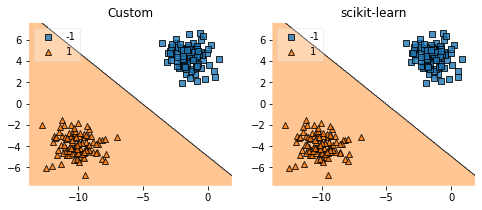

In [5]:
# Visualize performance. 
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3))

# My implimentation vs sklearn's.
plot_decision_regions(X, y_int_32, clf = model,         legend = 2, ax = ax0)
plot_decision_regions(X, y_int_32, clf = sklearn_model, legend = 2, ax = ax1)

ax0.set_title("Custom")
ax1.set_title("scikit-learn")

plt.savefig(
    "./svm_comparison.png", 
    transparent = False, 
    bbox_inches = "tight", 
    pad_inches = 0,
    dpi = 300
)
plt.show()